# Outline of the financial problem and numerical procedure

## Financial Problem

Given the expected value of the discounted payoff under the risk-neutral density $\mathbb{Q}$

$$
V(S,t) = e^{-r(T-t)}\mathbb{E}^\mathbb{Q}[\mathbf{Payoff}(S_{T})]
$$

Initial example data:

$$
\begin{align*}
\text{Today's stock price }S_{0} &= 100
\\ 
\text{Strike E} &= 100
\\
\text{Time to expiry }(T - t) &= \text{1 year}
\\
\text{volatility } \sigma &= 20 \%
\\
\text{constant risk-free interest rate }r &= 5 \%
\end{align*}
$$

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define parameters and variables
S0 = 100
E = 100
T = 1
vol = 0.2
risk_free_rate = 0.05

In this report, I will use the Monte Carlo method to simulate risk neutral random walk and then value the option under the risk neutral framework.

The pricing algorithm:

1. Simulate the risk-neutral random walk starting at today’s value of the asset over the required time horizon. This gives one realization of the underlying price path.

2. For this realization calculate the option payoff.

3. Perform many more such realizations over the time horizon.

4. Calculate the average payoff over all realizations.

5. Take the present value of this average; this is the option value.

## Simulating path using Euler - Maruyama Scheme

A geometric Brownian motion with a stochastic differential equation (SDE) is given as:
$$
dS = r S \: dt + \sigma S \: dW
$$

Where:

* $S$ is the price of the underlying

* $\sigma$ is constant volatility

* $r$ is the constant risk-free interest rate

* $W$ is the brownian motion.

Consider $V(S) = \log S$

First order derivative:

$$
\frac{dV}{dS}= \frac{1}{S} \tag{1}
$$

Second order derivative:

$$
\frac{d^{2}V}{dS^{2}} = - \frac{1}{S^{2}} \tag{2}
$$

Using this result for $V = V(S,t)$ [[1]](#1):

$$
\begin{align*}\\
 dV &= \left(r S \frac{dV}{dS} + \frac{1}{2} \sigma^{2} S^{2} \frac{d^{2}V}{dS^{2}} \right)dt     + \left(\sigma S \frac{dV}{dS} \right)dW
\end{align*} \tag{3}
$$

Subtitude (1) and (2) into (3) we have:

$$
\begin{align*}
d(\log S) &= \left(rS\left(\frac{1}{S}\right) + \frac{1}{2} \sigma^2 S^2 \left(-\frac{1}{S^2}\right) \right)dt + \sigma S \left(\frac{1}{S}\right) dW
\\\\
&= \left(r-\frac{1}{2} \sigma^{2}\right) d t+\sigma \: dW
\end{align*}
$$

Integrating both sides between 0 and $t$

$$
\begin{align*}
\int_{0}^{t} d(\log S) &= \int_{0}^{t} \left(r - \frac{1}{2} \sigma^{2}\right) d\tau + \int_{0}^{t} \sigma dW \quad (t > 0) 
\\\\
\log \frac{S_t}{S_0} &= \left(r - \frac{1}{2} \sigma^{2}\right) t + \sigma(W(t) - W(0))
\end{align*}
$$

Assuming $W (0) = 0$ and $S (0) = S_{0}$, the exact solution becomes:

$$
S(t)=S_{0} \exp \left(\left(r-\frac{1}{2} \sigma^{2}\right) t+\sigma W(t)\right) \tag{4}
$$

To approximate (4), I am going to use the Euler - Maruyama scheme [[2]](#2):

$$
d S = rS \: dt + \sigma S \sqrt{dt} \: \phi
$$

Where $\phi$ is from a standardized normal distribution. This numerical method has an error of $O(\delta t)$.

Using (4) we can derive the Euler - Maruyama scheme to simulate each asset path:

$$
S_{t+ dt} = S_t \exp \left(\left(r-\frac{1}{2} \sigma^{2}\right) dt+\sigma \sqrt{d t} \: \phi \right) \tag{5}
$$


For the random number generator used to generate standard normal variables $\phi$, I will utilize the `np.random.standard_normal()` method. This code is influenced by the work from Python Lab 6: Monte Carlo Simulation [[5]](#5)

In [3]:
# define simulation function
def simulate_path(s0, risk_free_rate, vol, horizon, timesteps, n_sims):
    
    # choose the random seed
    seed = 2023
    rng = np.random.default_rng(seed)
    
    # read the params
    S0 = s0 
    r = risk_free_rate
    T = horizon
    t = timesteps
    n = n_sims
    vol = vol
    
    # define dt
    dt = T/t
    
    # simulate path
    S = np.zeros((t,n))
    S[0] = S0
    for i in range(0, t-1):
        w = rng.standard_normal(n)
        S[i+1] = S[i] * np.exp((r - 0.5 * vol**2)*dt + vol*np.sqrt(dt)*w)
    return S

I will choose:

1. Number of paths: `100,000`

2. Time steps: `252` trading days

In [4]:
# Monte Carlo parameters
n = 100000  # Number of iterations
t = 252     # Number of trading days

In [5]:
# Assign simulated price path to dataframe for analysis and plotting
S = pd.DataFrame(simulate_path(S0,risk_free_rate,vol,T,t,n))

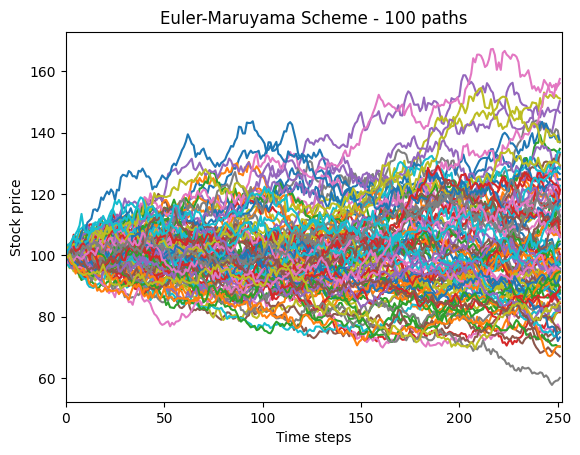

In [6]:
# Plot initial 100 simulated paths
plt.plot(S.iloc[:,:100])
plt.xlabel('Time steps')
plt.xlim(0,t)
plt.ylabel('Stock price')
plt.title('Euler-Maruyama Scheme - 100 paths');

## Exotic Options Pricing

Using the simulation from the previous section, I will calculate the payoff of the options for all realizations of the asset path. Then, I will take the expectation of the option price, discounted back to the present value.

### Asian Options Pricing

An Asian option is an option where the payoff depends on the average price of the underlying asset over a certain period of time. Averaging can be either be Arithmetic or Geometric. There are two types of Payoff types: average rate, where averaging price is used in place of underlying price; and average strike, where averaging price is used in place of strike [[3]](#3)

Average strike call:
$$
\max(S-A,0)
$$

Average strike put:
$$
\max(A-S,0)
$$

Average rate call:
$$
\max(A-E,0)
$$

Average rate put:
$$
\max(E-A,0)
$$

The value of our Asian Options is a function of three variables, $V (S, A, t)$.

Where $A$ is a Average tracking variable 

$$
A_{i}= \frac{1}{i} \sum_{k=1}^{i} S\left(t_{k}\right)
$$

In this function, I will use:

1. Payoff Type: Average rate 

2. Type of Average: Athrimetic Average

Under the risk-neutral framework, we assume the asset is going to earn, on average, the risk-free interest rate. Hence, the option value at time $t$ would simply be the discounted value of the expected payoff.

**The payoff of the Asian options is given by**

$$
\begin{align*}
C(S,t) = e^{-r(T-t)}\mathbb{E}[\max(A-E,0)]
\\\\
P(S,t) = e^{-r(T-t)}\mathbb{E}[\max(E-A,0)]
\end{align*}
$$

In [7]:
# Average price
A = S.mean(axis=0)
C_asian = np.exp(-risk_free_rate*T) * np.mean(np.maximum(A-E,0))
P_asian = np.exp(-risk_free_rate*T) * np.mean(np.maximum(E-A,0))
# Print the values
print(f"Asian Call Option Value is {C_asian:0.4f}")
print(f"Asian Put Option Value is {P_asian:0.4f}")

Asian Call Option Value is 5.7608
Asian Put Option Value is 3.3467


### Lookback Options Pricing

The Lookback Options have a payoff that depends on the maximum or minimum of the realized asset price. There are two types of payoff: The rate and the strike option, also called the **fixed strike** and the **floating strike** respectively [[4]](#4).

Variable $M_{\max}$ as the realized maximum and $M_{\min}$ as the realized minimum of the asset from the start of the sampling period $t = 0$ until the current time $t$:

$$
\begin{align*}
M_{\max} &= \max_{0 \leq \tau \leq t} S(\tau)
\\\\
M_{\min} &= \min_{0 \leq \tau \leq t} S(\tau)
\end{align*}
$$

The payoff function becomes

Floating strike lookback call:
$$
\max(S - M_{\min},0)
$$

Floating strike lookback put:
$$
\max( M_{\max} - S,0)
$$

Fixed strike lookback call:
$$
\max(M_{\max} - E,0)
$$

Fixed strike lookback put:
$$
\max(E - M_{\min},0)
$$

The value of our lookback option is a function of three variables, $V (S, M, t)$. In this function, I will use:

1. Payoff Type: Fixed strike 

2. Maximum measurement: Continuous

The algorithm is to price option of each path and then calculate the average payoff over all realizations. Take the present value of this average which is the value of the option.

**The payoff of the Lookback options is given by**

$$
\begin{align*}
C(S,t) = e^{-r(T-t)}\mathbb{E}[\max(M_{\max} - E,0)]
\\\\
P(S,t) = e^{-r(T-t)}\mathbb{E}[\max(E - M_{\min},0)]
\end{align*}
$$

In [8]:
# Tracking Variable for Maximum and Minimum
M_max = np.max(S,axis=0)
M_min = np.min(S,axis=0)
# Pricing Options
C_lookback = np.exp(-risk_free_rate*T) * np.mean(np.maximum(M_max-E,0))
P_lookback = np.exp(-risk_free_rate*T) * np.mean(np.maximum(E-M_min,0))
# Print the values
print(f"Lookback Call Option Value is {C_lookback:0.4f}")
print(f"Lookback Put Option Value is {P_lookback:0.4f}")

Lookback Call Option Value is 18.3007
Lookback Put Option Value is 11.7160


# Varying the Initial Data


Using the previous code for our Monte Carlo simulation and exotic options pricing, I will create an `asian()` function and a `lookback()` function to calculate option values for different parameters. This method makes it easy to iterate over various values of a single parameter in a list `[]` and then compile them in the same table for comparison.

In [9]:
# Setting the random seed
seed = 2023
rng = np.random.default_rng(seed)

In [10]:
def asian(s0, strike, risk_free_rate, vol, horizon, timesteps, n_sims, option_type="C"):
    # Input validation
    if option_type not in ["C", "P"]:
        raise ValueError("Wrong Option Type. Use 'C' for Call option and 'P' for Put option.")

    # Euler-Maruyama Scheme
    S0 = s0
    E = strike
    r = risk_free_rate
    T = horizon
    t = timesteps
    n = n_sims
    dt = T / t

    # Simulate path
    S = np.zeros((t,n))
    S[0] = S0
    for i in range(0, t-1):
        w = rng.standard_normal(n)
        S[i+1] = S[i] * np.exp((r - 0.5 * vol**2)*dt + vol*np.sqrt(dt)*w)
    
    # Average price
    A = np.mean(S, axis=0)

    # Calculate option value
    if option_type == "C":
        option_value = np.exp(-r * T) * np.mean(np.maximum(A - E, 0))
    elif option_type == "P":
        option_value = np.exp(-r * T) * np.mean(np.maximum(E - A, 0))

    return option_value


And doing the same to create `lookback()` function to price Lookback options

In [11]:
def lookback(s0, strike, risk_free_rate, vol, horizon, timesteps, n_sims, option_type="C"):
    # Input validation
    if option_type not in ["C", "P"]:
        raise ValueError("Wrong Option Type. Use 'C' for Call option and 'P' for Put option.")

    # Euler-Maruyama Scheme
    S0 = s0
    E = strike
    r = risk_free_rate
    T = horizon
    t = timesteps
    n = n_sims
    dt = T / t

    # Simulate path
    S = np.zeros((t,n))
    S[0] = S0
    for i in range(0, t-1):
        w = rng.standard_normal(n)
        S[i+1] = S[i] * np.exp((r - 0.5 * vol**2)*dt + vol*np.sqrt(dt)*w)

    # Calculate maximum and minimum
    M_max = np.max(S, axis=0)
    M_min = np.min(S, axis=0)

    # Calculate option value
    if option_type == "C":
        option_value = np.exp(-r * T) * np.mean(np.maximum(M_max - E, 0))
    elif option_type == "P":
        option_value = np.exp(-r * T) * np.mean(np.maximum(E - M_min, 0))

    return option_value

Testing the function with our previous results for Asian Options

In [12]:
asian(100,100,0.05,0.2,1,252,100000,"C"), asian(100,100,0.05,0.2,1,252,100000,"P")


(5.7607544229446175, 3.338423344900537)

And for the Lookback Options

In [13]:
lookback(100,100,0.05,0.2,1,252,100000,"C"), lookback(100,100,0.05,0.2,1,252,100000,"P")

(18.318029560345444, 11.72906802746889)

Both functions are working as expected. In the next section, I will vary the parameters of the functions and observe the effect on option prices.


## Vary the Volatility $\sigma$

Now, let's vary the volatility for five different levels: $\sigma_1 = 10\%$, $\sigma_2 = 15\%$, $\sigma_3 = 20\%$, $\sigma_4 = 25\%$ and $\sigma_5 = 30\%$.

In [14]:
vol_set = [0.10,0.15,0.2,0.25,0.30]
asian_calls = [asian(100,100,0.05,vol,1,252,100000,"C") for vol in vol_set]
asian_puts = [asian(100,100,0.05,vol,1,252,100000,"P") for vol in vol_set]
lookback_calls = [lookback(100,100,0.05,vol,1,252,100000,"C") for vol in vol_set]
lookback_puts = [lookback(100,100,0.05,vol,1,252,100000,"P") for vol in vol_set]

In [15]:
# Create a dictionary with the sets and headers
data1 = {
    'Volatility': vol_set,
    'Asian Call': asian_calls,
    'Asian Put': asian_puts,
    'Lookback Call': lookback_calls,
    'Lookback Put': lookback_puts
}
# Create a DataFrame
df1 = pd.DataFrame(data1).set_index('Volatility')

df1

,Asian Call,Asian Put,Lookback Call,Lookback Put
Volatility,,,,
0.10,3.643966,1.227130,10.400157,5.091968
0.15,4.688426,2.246732,14.295536,8.445543
0.20,5.773823,3.339635,18.324467,11.730053
0.25,6.798326,4.434070,22.458120,14.947722
0.30,7.976223,5.516147,26.726107,18.084287


It appears that both Asian and Lookback option prices increase when volatility rises and decrease when volatility falls. The direction for both Call options and Put options is very much similar. The higher the volatility, the higher the option price. However, it seems that Asian options are less sensitive to changes in volatility. This could be due to the effect of averaging the price of the underlying, which mitigates the impact of sudden changes.

The price of Lookback options is increasing significantly. This could be attributed to the high volatility that increases the probability of extreme prices, consequently raising the maximum value $M_{\max}$ and minimum value $M_{\min}$, thereby increasing the price of the options.

## Vary the inital stock price $S_0$

Let's vary the initial stock price at five different levels: 90, 95, 100, 105 and 110.

In [16]:
S0_set = [90, 95, 100, 105, 110]
asian_calls = [asian(S0,100,0.05,0.2,1,252,100000,"C") for S0 in S0_set]
asian_puts = [asian(S0,100,0.05,0.2,1,252,100000,"P") for S0 in S0_set]
lookback_calls = [lookback(S0,100,0.05,0.2,1,252,100000,"C") for S0 in S0_set]
lookback_puts = [lookback(S0,100,0.05,0.2,1,252,100000,"P") for S0 in S0_set]

In [17]:
# Create a dictionary with the sets and headers
data2 = {
    'S0': S0_set,
    'Asian Call': asian_calls,
    'Asian Put': asian_puts,
    'Lookback Call': lookback_calls,
    'Lookback Put': lookback_puts
}
# Create a DataFrame
df2 = pd.DataFrame(data2).set_index('S0')

df2

,Asian Call,Asian Put,Lookback Call,Lookback Put
S0,,,,
90,1.547673,8.927391,8.928741,20.075008
95,3.236557,5.694676,13.146024,15.886136
100,5.774358,3.331288,18.302326,11.699184
105,9.072765,1.770047,23.966002,8.254617
110,13.065179,0.875448,29.615374,5.697519


The price of Out of The Money (OTM) call options is significantly lower compared to At the Money (ATM) call and In the Money (ITM) call options, as expected. For Asian Options, the price is notably lower. This can be attributed to the effect of averaging the price of the underlying, which makes it more challenging for the average to increase.

In the case of Lookback Options, since the payoff depends on the maximum and minimum of the underlying, it appears that the price of the options doesn't change as drastically

## Vary the strike price $E$

Let's vary the strike price at five different levels: 90, 95, 100, 105 and 110.

In [18]:
strike_set = [90, 95, 100, 105, 110]
asian_calls = [asian(100,strike,0.05,0.2,1,252,100000,"C") for strike in strike_set]
asian_puts = [asian(100,strike,0.05,0.2,1,252,100000,"P") for strike in strike_set]
lookback_calls = [lookback(100,strike,0.05,0.2,1,252,100000,"C") for strike in strike_set]
lookback_puts = [lookback(100,strike,0.05,0.2,1,252,100000,"P") for strike in strike_set]

In [19]:
# Create a dictionary with the sets and headers
data3 = {
    'Strike': strike_set,
    'Asian Call': asian_calls,
    'Asian Put': asian_puts,
    'Lookback Call': lookback_calls,
    'Lookback Put': lookback_puts
}
# Create a DataFrame
df3 = pd.DataFrame(data3).set_index('Strike')

df3

,Asian Call,Asian Put,Lookback Call,Lookback Put
Strike,,,,
90,12.507546,0.655818,27.858083,4.694285
95,8.778878,1.650215,22.925895,7.742152
100,5.716656,3.321274,18.264279,11.735440
105,3.495136,5.864080,14.043786,16.491042
110,1.968770,9.065262,10.597087,21.231782


These results closely resemble our earlier observations when we varied the initial stock price data. We can still draw the same conclusions for both Asian Options and Lookback Options. The pricing patterns remain consistent, with Asian Options generally having lower prices compared to Lookback Options under similar parameters.

## Vary the risk-free interest rate $r$

Let's vary the risk-free rate at five different levels: 0%, 3%, 5%, 7% and 9%

In [20]:
r_set = [0, 0.03, 0.05, 0.07, 0.09]
asian_calls = [asian(100,100,r,0.2,1,252,100000,"C") for r in r_set]
asian_puts = [asian(100,100,r,0.2,1,252,100000,"P") for r in r_set]
lookback_calls = [lookback(100,100,r,0.2,1,252,100000,"C") for r in r_set]
lookback_puts = [lookback(100,100,r,0.2,1,252,100000,"P") for r in r_set]

In [21]:
# Create a dictionary with the sets and headers
data4 = {
    'Risk-free Rate': r_set,
    'Asian Call': asian_calls,
    'Asian Put': asian_puts,
    'Lookback Call': lookback_calls,
    'Lookback Put': lookback_puts
}
# Create a DataFrame
df4 = pd.DataFrame(data4).set_index('Risk-free Rate')

df4

,Asian Call,Asian Put,Lookback Call,Lookback Put
Risk-free Rate,,,,
0.00,4.593868,4.566435,16.183966,14.364974
0.03,5.308522,3.779141,17.482078,12.745313
0.05,5.720296,3.327718,18.225063,11.668297
0.07,6.241525,2.928298,19.153273,10.770280
0.09,6.767847,2.532560,20.179381,9.938444


Unlike volatility, the risk-free rate only affects the drift or the deterministic part of the SDE and the discounted factor. The change in $r$ causes the option prices to move in different directions. Despite that, the result on the option price is linear, and the price of options changes proportionally to the change in $r$.

We won't be discussing the change in $T$ since it only affects the discounted factor.

# Observations and problems encountered

**Observations:**

* The volatility of the average stock price over time is lower than the volatility of the individual stock. This results in significantly lower prices for Asian Options compared to Lookback Options under the same parameters. As a result, the reduction in the upfront premium in an option contract tends to make Asian Options more appealing to investors.

* The price of Lookback Options is significantly higher than that of Asian Options. This can be attributed to the extreme payoff structure of Lookback Options, which tends to make the contracts more expensive.

* When varying the initial price data, we have observed changes in the option prices, particularly the volatility $\sigma$, which significantly affects the prices of the options.

* The Risk Neutral Framework makes the pricing of these options relatively straightforward, especially when using the Monte Carlo Method.

* The Euler-Maruyama Scheme is relatively easy to program, but the quality of the entire algorithm depends on the quality of the pseudo-random number generator (RNG) methods. To maintain consistent results, I have adopted a method that creates a global numpy RNG and passes the seed only once. This approach ensures ease of reproduction without affecting the randomness of the results [[6]](#6).

* The computational time is quite low and proportional to the number of simulations. Increasing the number of simulations yields a more accurate result but at the cost of longer computing time. Perhaps the Finite Difference Method can help reduce the calculation time significantly.



**Problems:**

* In the Asian Options pricing function, I haven't utilized the Average Strike payoff and Geometric Average sampling technique.

* In the Lookback Options pricing function, I haven't incorporated the Lookback Floating Strike Payoff and Discrete sampling technique.

* The output of the Euler-Maruyama Scheme in (5) depends on the quality of the pseudo-random number generator (RNG) for $\phi$. I only used the `np.random()` method and didn't have the time to compare the effects of different RNG methods on the output of our Monte Carlo model.

* The Euler-Maruyama Scheme has an error of $O(\delta t)$. Better approximations, such as the Milstein method with an error of $O(\delta t^2)$, could be implemented to improve the model.

# Conclusion

Under the risk-neutral framework, the fair value of an option is the present value of the expected payoff at expiry under a risk-neutral random walk for the underlying.

$$
V(S,t) = e^{-r(T-t)}\mathbb{E}^\mathbb{Q}[\mathbf{Payoff}(S_{T})]
$$

In this expression, we see the risk-free interest rate playing two distinct roles. First, it is used for discounting the payoff to the present. This is the term $e^{-r(T - t)}$ outside the expectation. Second, the drift in the GBM in the risk-neutral world is $rS \: dt$ in a time step $dt$. By varying $r$, I have observed changes in option prices proportionally to the change in the interest rate.

I have successfully priced Asian Options and Lookback Options using the Euler-Maruyama Scheme. The Monte Carlo algorithm is easy to program. The more simulations I use, the better accuracy I will achieve. The algorithm is also useful for pricing strong-path-dependent contracts, such as Asian Options and Lookback Options. The code is easy to reproduce, and I can create a Python class for later use. However, the quality of the simulation is crucial for calculating the option price. This quality is heavily influenced by the pseudo RNG method.

After pricing the options, I noticed that the price of Asian Options is lower compared to Lookback Options with similar parameters. I also observed the effect of varying the volatility, initial stock price, strike price, and risk-free rate on the option prices. The change caused by volatility is more significant. This result indicates that the better the approximation of volatility, the more confident the option price is.

I believe using the Finite Difference Method (FDM) for pricing these options should be optimal since it is well-suited for three-dimensional problems. FDM will reduce the calculation time and an optimal solution for pricing embedded decision contracts, such as American Options or Bermuda Options. If I were to do this again, I would like to try the Finite Difference Method and compare the results between the Monte Carlo Simulation and Finite Difference Method.

# References

<a id="1">[1]</a> Module 1 - Lecture 4,Apply Ito $\text{III}$ for $V = V(t,X)$

<a id="2">[2]</a> Paul Wilmott on Quantitative Finance, Chapter 80, Page 1266

<a id="3">[3]</a> Paul Wilmott on Quantitative Finance, Chapter 25, Page 428

<a id="4">[4]</a> Paul Wilmott on Quantitative Finance, Chapter 26, Page 445

<a id="5">[5]</a> Pythonlab 6: Monte Carlo Simulation

<a id="6">[6]</a> Good practices with numpy random number generators, Albert Thomas (https://albertcthomas.github.io/good-practices-random-number-generators/)